In [1]:
!pip install qiskit==0.43.2 qiskit-machine-learning==0.6.0 qiskit-algorithms==0.2.0 pylatexenc

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# STEP 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit_aer import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.algorithms import QSVC
from qiskit.visualization import circuit_drawer

In [4]:
# STEP 2: Load Data
def load_parkinsons_data():
    url = "https://raw.githubusercontent.com/ncdingari/Datasets/refs/heads/master/oxford-parkinsons/parkinsons_classification_data.csv"
    df = pd.read_csv(url)
    df = df.drop(columns=["name"])  # Drop string ID column
    X = df.drop(columns=["status"])
    y = df["status"]
    return X, y

In [5]:
# STEP 3: Preprocessing
def preprocess_data(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
# STEP 4: Train Classical SVM
def train_svm(X_train, y_train):
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm.fit(X_train, y_train)
    return svm

In [7]:
# STEP 5: Quantum SVM using Sampler + ComputeUncompute
def train_qsvm(X_train, y_train, selected_feature_names):
    feature_dim = len(selected_feature_names)
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train, y_train)
    return qsvc

In [8]:
# STEP 6: Evaluation
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ {model_name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc

In [9]:
# STEP 7: Plot ROC Curve (SVM)
def plot_roc_svm(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve - Classical SVM')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

In [10]:
# STEP 8: Plot ROC Curve (QSVM workaround)
def plot_roc_qsvm(qsvc_model, X_test, y_test):
    try:
        decision_scores = qsvc_model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, decision_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'Quantum SVM (AUC = {roc_auc:.2f})', color='purple')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Quantum SVM')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.legend()
        plt.show()
    except Exception as e:
        print("⚠️ QSVM ROC Curve could not be plotted:", e)

In [11]:
# STEP 9: Visualize Quantum Feature Map
def plot_feature_map(selected_features):
    print("\n🌀 Feature Map (Quantum Circuit):")
    feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=2, entanglement="linear")
    fig = circuit_drawer(feature_map, output='mpl')
    fig.suptitle("ZZ Feature Map", fontsize=14)
    fig.tight_layout()
    fig.show()

In [12]:
# STEP 10: Main Comparison Pipeline
def compare_svm_qsvm():
    print("🔄 Loading and preprocessing data...")
    selected_features = ["MDVP:Fo(Hz)", "MDVP:Fhi(Hz)"]
    X, y = load_parkinsons_data()
    X = X[selected_features]
    X_train, X_test, y_train, y_test = preprocess_data(X, y)

    plot_feature_map(selected_features)

    print("\n🧠 Training Classical SVM...")
    svm_model = train_svm(X_train, y_train)

    print("\n⚛️ Training Quantum SVM (QSVM)...")
    qsvm_model = train_qsvm(X_train, y_train, selected_features)

    print("\n📊 Evaluating Models:")
    acc_svm = evaluate_model(svm_model, X_test, y_test, "Classical SVM")
    acc_qsvm = evaluate_model(qsvm_model, X_test, y_test, "Quantum SVM")

    print("\n📈 ROC Curve Analysis:")
    plot_roc_svm(svm_model, X_test, y_test)
    plot_roc_qsvm(qsvm_model, X_test, y_test)

    print("\n✅ Summary:")
    print(f"Classical SVM Accuracy: {acc_svm:.4f}")
    print(f"Quantum SVM Accuracy  : {acc_qsvm:.4f}")

🔄 Loading and preprocessing data...

🌀 Feature Map (Quantum Circuit):

🧠 Training Classical SVM...

⚛️ Training Quantum SVM (QSVM)...

📊 Evaluating Models:

✅ Classical SVM Accuracy: 0.7692
              precision    recall  f1-score   support

           0       0.33      0.29      0.31         7
           1       0.85      0.88      0.86        32

    accuracy                           0.77        39
   macro avg       0.59      0.58      0.58        39
weighted avg       0.76      0.77      0.76        39



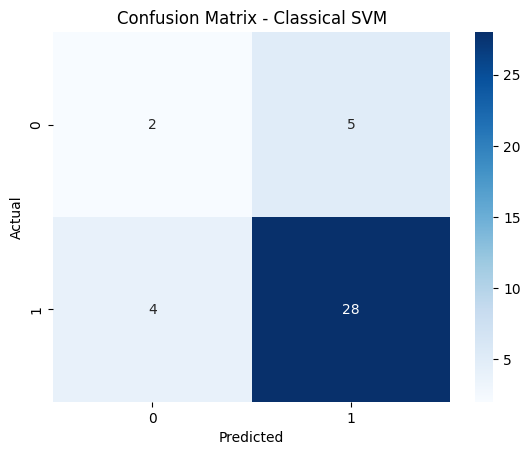


✅ Quantum SVM Accuracy: 0.8205
              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.88      0.91      0.89        32

    accuracy                           0.82        39
   macro avg       0.69      0.67      0.68        39
weighted avg       0.81      0.82      0.81        39



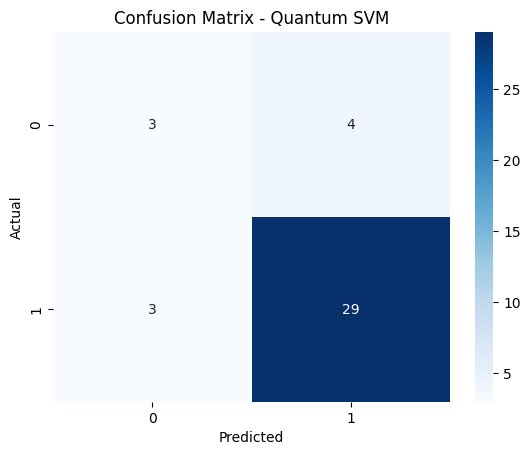


📈 ROC Curve Analysis:


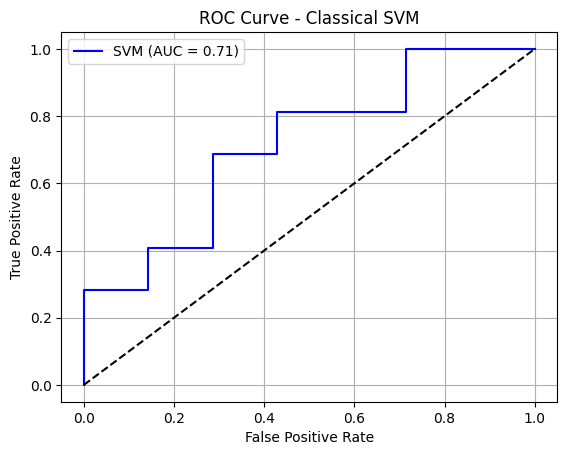

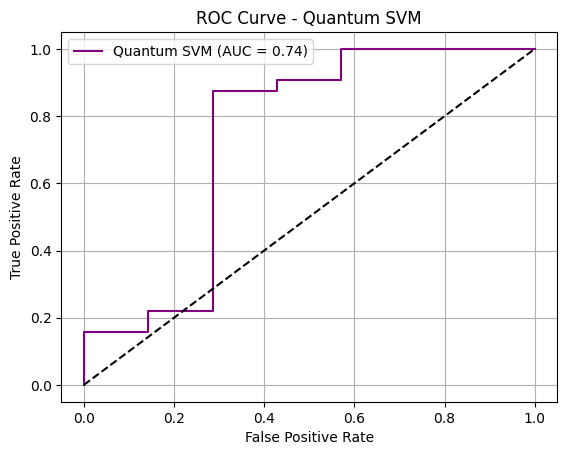


✅ Summary:
Classical SVM Accuracy: 0.7692
Quantum SVM Accuracy  : 0.8205


In [13]:
# Run the comparison pipeline
compare_svm_qsvm()